In [172]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

CIIexps = {}

In [243]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

TIM.Daz = 10 * u.deg 
TIM.Del = 10 * u.deg
TIM.SW.dnu = TIM.SW.dnu
TIM.LW.dnu = TIM.LW.dnu
# TIM.SW.NEI = 7.9e6 * u.Jy * u.s**0.5
# TIM.LW.NEI = 3.2e6 * u.Jy * u.s**0.5
TIM.SW.NEI = .17e6 * u.Jy * u.s**0.5
TIM.LW.NEI = .13e6 * u.Jy * u.s**0.5
TIM.time = 100 * u.hr

In [244]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [245]:
Pn_single(TIM.LW.NEI, TIM.time, TIM.LW.num_dets, 1.3, TIM.Daz, TIM.Del, TIM.LW.dnu, l.CII.nu)

3813560477.1312833

In [246]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bands = ['SW', 'SW', 'LW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2140040013.py:19: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2140040013.py:36: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2140040013.py:37: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2140040013.py:38: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [247]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [TIM[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [TIM[band].min for band in bands]
insmaxs = [TIM[band].max for band in bands]
insdnu = [TIM[band].dnu for band in bands]
linenu = l.CII.nu
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnu)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [248]:
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

In [249]:
KSs = [data['k'] for data in datas]
psCIIs = [data['ps_cii'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIs]

In [250]:
binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_single(TIM[band].NEI, TIM.time, TIM[band].num_dets, CALCZ, TIM.Daz, TIM.Del, TIM[band].dnu, l.CII.nu) for CALCZ, band in zip(CALCZs, bands)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

In [251]:
Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(psCII + Pn) ** 2 / Nmode for psCII, Pn, Nmode in zip(psCIIsmedian, Pns, Nmodes_ones)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/1340170149.py:1: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCIIsmedian, Pns, binned_total, Nmodes)]


In [252]:
# CIIexps['PTIM_1'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM 1 $\deg^2$, 200 hours')
# CIIexps['PTIM_p2'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM 0.2 $\deg^2$, 200 hours')
# CIIexps['TIM_NG'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM NG 4 $\deg^2$, 200 hours')
# CIIexps['TIM_NG_9'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'TIM NG 9 $\deg^2$, 200 hours')
# CIIexps['SpTIM_4'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM lite 4 $\deg^2$, 100 hours')
# CIIexps['SpTIM_9'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM lite 9 $\deg^2$, 100 hours')
CIIexps['SpTIM_100'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM 100 $\deg^2$, 1000 hours')
# CIIexps['SpTIMdeep'] = (KSs, psCIIsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'SpTIM deep 1 $\deg^2$, 1000 hours')

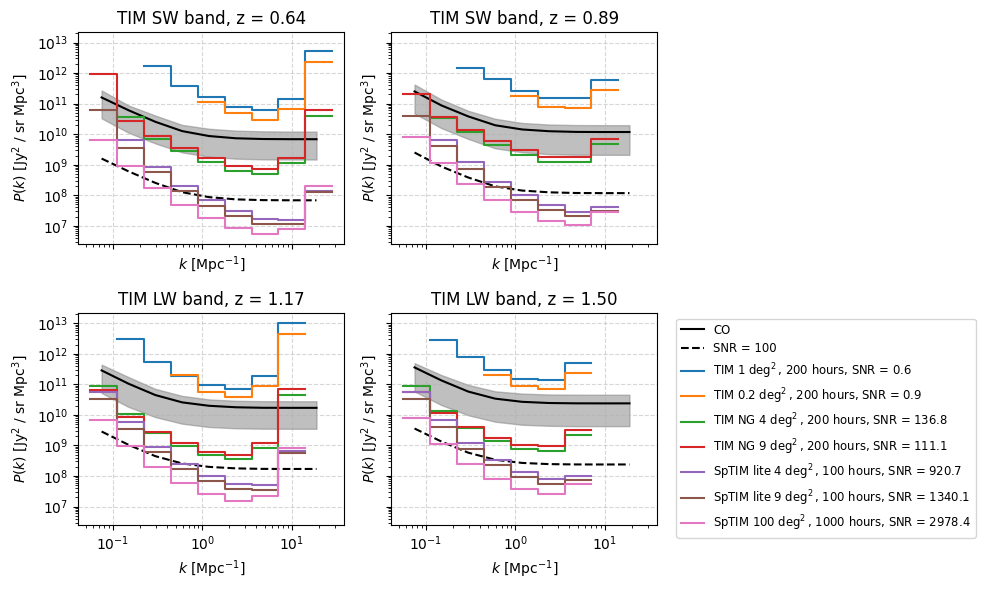

In [253]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCIIsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in CIIexps.values():
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label+f', SNR = {np.nansum(SNR):.1f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [254]:
import pickle

with open('CIIexps.pkl', 'wb') as f:
    pickle.dump(CIIexps, f)

In [38]:
with open('CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

COexps = {}

In [275]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

FYST = p.FYST
TIM = p.TIM

TIM.Daz = 10 * u.deg
TIM.Del = 10 * u.deg
FYST.time = 4000 * u.hr

In [276]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [277]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bands = ['CO43', 'CO43', 'CO54', 'CO54']

LSbins = [ut.Survey(b, FYST[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2352813908.py:20: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2352813908.py:37: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2352813908.py:38: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2352813908.py:39: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [278]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [FYST[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [FYST[band].min for band in bands]
insmaxs = [FYST[band].max for band in bands]
insdnus = [FYST.dnu for band in bands]
linenus = [l.CO43.nu, l.CO43.nu, l.CO54.nu, l.CO54.nu]
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu, linenu in zip(CALCZs, insdnus, linenus)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax, linenu in zip(CALCZs, insmins, insmaxs, linenus)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [279]:
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

KSs = [data['k'] for data in datas]
psCOs = [data['ps_co'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_single(FYST.NEI * u.sr, FYST.time, FYST.nbeams, CALCZ, TIM.Daz, TIM.Del, FYST.dnu, linenu) for CALCZ, linenu in zip(CALCZs, linenus)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

In [280]:
Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2156175427.py:1: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]


In [281]:
# COexps['EoRSpec_lite'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 100 hours')
# COexps['EoRSpec_p2'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 0.2 $\deg^2$, 200 hours')
# COexps['EoRSpec_deep'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 2000 hours')
COexps['EoRSpec_wide'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 100 $\deg^2$, 4000 hours')
# COexps['EoRSpec_DSS_TIM'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 1 $\deg^2$, 500 hours')
# COexps['EoRSpec_DSS'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'EoRSpec 4 $\deg^2$, 2000 hours')

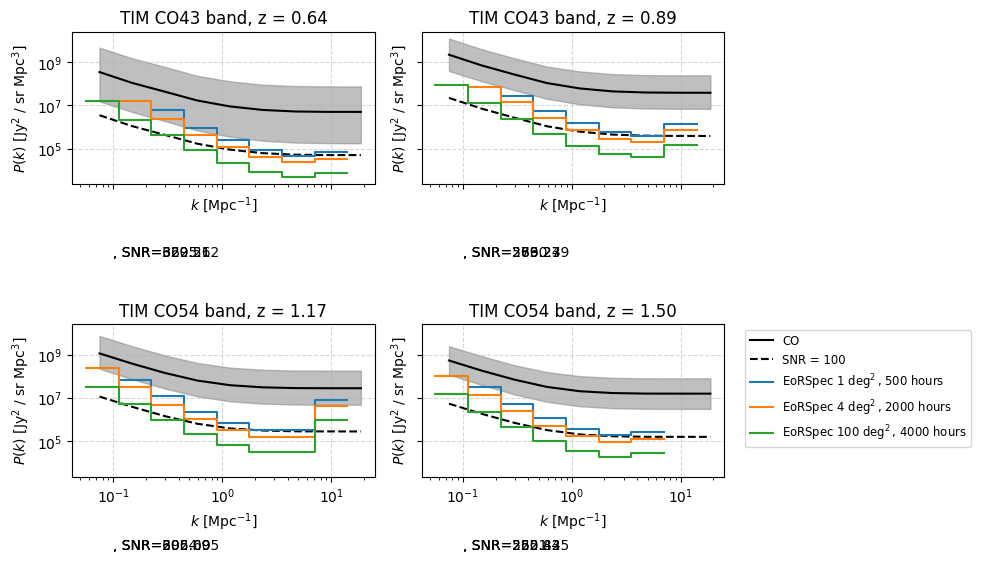

In [282]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in COexps.values():
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
        ax.text(.1, 1, f', SNR={np.nansum(SNR):.2f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [283]:
with open('COexps.pkl', 'wb') as f:
    pickle.dump(COexps, f)

In [333]:
import pickle
cross_exps = {}
with open('CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['PTIM_1', 'PTIM_p2', 'TIM_NG', 'TIM_NG_9', 'SpTIM_4', 'SpTIM_9', 'SpTIM_100'])
dict_keys(['EoRSpec_DSS_TIM', 'EoRSpec_DSS', 'EoRSpec_wide'])


In [334]:
combos = [
    ('PTIM_1', 'EoRSpec_DSS_TIM'),
    ('TIM_NG', 'EoRSpec_DSS'),
    ('SpTIM_100', 'EoRSpec_wide')]

bands = ['SW', 'LW', 'SW', 'LW']

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_co'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [335]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/1860415682.py:6: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


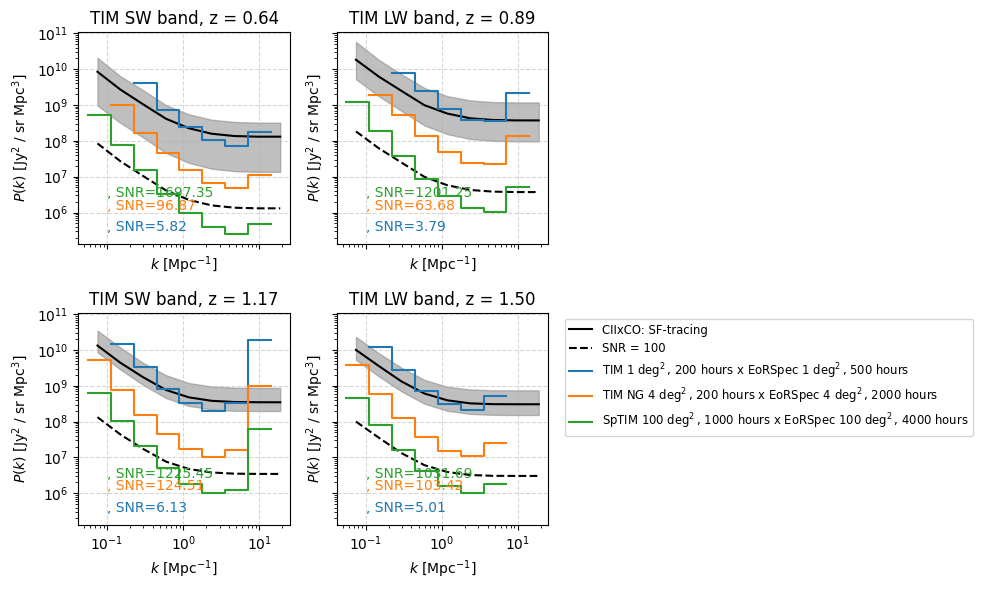

In [336]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    # ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    # ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
        ax.text(.1, 3e5*(j+1)**2, f', SNR={np.nansum(SNR):.2f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/3196476276.py:40: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


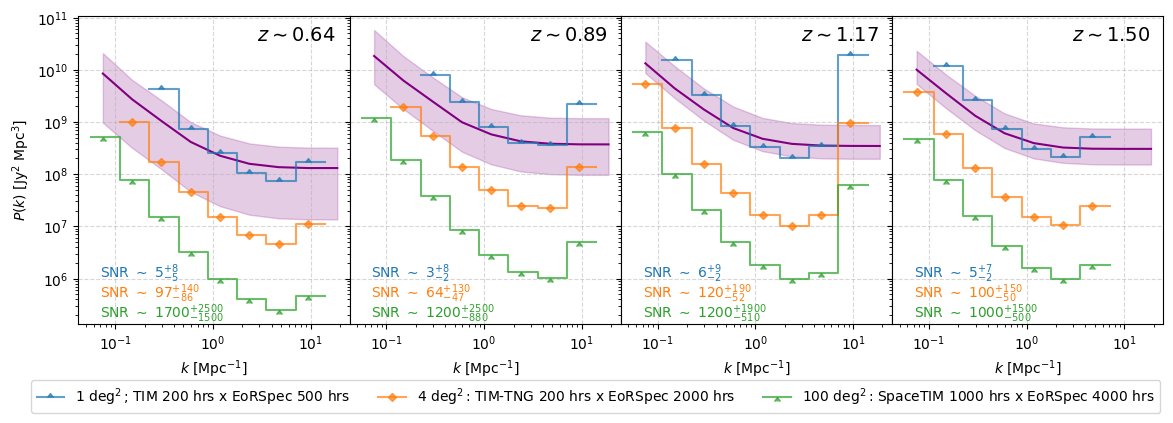

In [344]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'purple'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; TIM 200 hrs x EoRSpec 500 hrs",
    r"4 $\deg^2$: TIM-TNG 200 hrs x EoRSpec 2000 hrs",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x EoRSpec 4000 hrs"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
        
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        snrtext = r'SNR $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        ax.text(.08, .15-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    ax.text(.95, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(-.2, -.16), loc='upper left', fontsize=10, ncol=3)

plt.savefig("../figs/preds/CIIxCO_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

HIexps = {}

In [4]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
LADUMA = p.LADUMA

TIM.Daz = 1 * u.deg
TIM.Del = 1 * u.deg
LADUMA.time = 100 * u.hr

In [5]:
nuz_unscaled = 0.00013158134920122447 / u.m**2
# nuz_unscaled = 1.0823287747453567e-05 / u.m**2

In [19]:
def Pn_interf(Tsys, t_surv, n_uz_unscaled, z, Daz, Del, dnuFWHM, nu_rest, Adish):
    # Tsys = Adish / (6.22 * u.m**2 / u.K) 
    A_surv = (Daz * Del).to(u.sr).value
    # dnu = dnuFWHM / np.sqrt(8 * np.log(2)), should just cancel out
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    lambdaobs = (cst.c / nu_rest * (1 + z)).to(u.m)
    FOV = (lambdaobs**2 / Adish).to('').value
    if FOV > A_surv:
        print(f'Warning: FOV {FOV:.2e} > A_surv {A_surv:.2e}, setting FOV = A_surv')
        A_surv = FOV
    n_uz = n_uz_unscaled * lambdaobs**2
    conv = 2 * Tsys * cst.k_B / Adish / np.sqrt(2 * t_surv)
    # conv = 2 * Tsys * cst.k_B / lambdaobs**2 / np.sqrt(2 * dnu * t_surv)
    # conv = Tsys / np.sqrt(2 * dnu * t_surv)
    Pn = conv**2 / n_uz * chi**2 * dchi_dnu * A_surv / FOV
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [18]:
Pn_interf(LADUMA.Tsys, LADUMA.time, nuz_unscaled, 0.5, TIM.Daz, TIM.Del, LADUMA.dnu, l.HI.nu, LADUMA.Adish)

622667.2707965714

In [20]:
def interf_kmodes(z, Adish, maxbaseline, az, el, dnu):
    lambdaobs = (l.HI.l * (1 + z.center)).to(u.m)
    FOV = (lambdaobs**2 / Adish).to('').value
    if FOV > (TIM.Daz * TIM.Del).to(u.sr).value:
        print(f'Warning: FOV {FOV:.2e} > A_surv {(TIM.Daz * TIM.Del).to(u.sr).value:.2e}, setting az, el = sqrt(FOV)')
        az = np.sqrt(FOV) * u.rad
        el = np.sqrt(FOV) * u.rad
    
    Dx = z.transScale(az)
    Dy = z.transScale(el)
    Dz = np.abs(cosmo.comoving_distance(z.front) - cosmo.comoving_distance(z.back))
    FWHM = (lambdaobs / maxbaseline) * u.rad
    
    dchi_dnu = (cst.c / cosmo.H(z.center) * (1 + z.center) ** 2 / l.HI.nu)
    dx = ut.transverse_scale(FWHM, z.center)
    dy = ut.transverse_scale(FWHM, z.center)
    dz = (dchi_dnu * dnu).to(u.Mpc)
    
    kx, ky, kz = np.meshgrid(ut.calc_k_modes(Dx, dx), ut.calc_k_modes(Dy, dy), 
                        ut.calc_k_modes(Dz, dz), indexing='ij')
    
    return np.stack((kx, ky, kz))

In [21]:
interf_kmodes(ut.zBin(TIM.SW.zmin, TIM.SW.zcen), LADUMA.Adish, LADUMA.maxbase, TIM.Daz, TIM.Del, LADUMA.dnu).shape

(3, 167, 167, 617)

In [22]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bands = ['SW', 'SW', 'LW', 'LW']

# LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [interf_kmodes(b, LADUMA.Adish, LADUMA.maxbase, TIM.Daz, TIM.Del, LADUMA.dnu) for b in bins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

# kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
# kxmaxs = [np.max(abs(kx)) for kx in kxs]
# kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
# kymaxs = [np.max(abs(ky)) for ky in kys]
# kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
# kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
# mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
# mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
# muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_60161/3667144398.py:20: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [23]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [(l.HI.l * (1 + b.center) / LADUMA.maxbase).to('') * u.rad for b in bins]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [LADUMA.min for band in bands]
insmaxs = [LADUMA.max for band in bands]
insdnus = [LADUMA.dnu for band in bands]
linenus = [l.HI.nu, l.HI.nu, l.HI.nu, l.HI.nu]
CALCZs = [b.center for b in bins]

In [24]:
import gc
sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
del sigxs
gc.collect()

sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
del sigys
gc.collect()

sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu, linenu in zip(CALCZs, insdnus, linenus)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
del sigzs
gc.collect()
wbeams = [wbx * wby * wbz for wbx, wby, wbz in zip(wbeamxs, wbeamys, wbeamzs)]
del wbeamxs, wbeamys, wbeamzs
gc.collect()

0

In [25]:
kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
del kminxs
gc.collect()
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
del kminys
gc.collect()
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax, linenu in zip(CALCZs, insmins, insmaxs, linenus)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
del kminzs
gc.collect()

whpfs = [whpx * whpy * whpz for whpx, whpy, whpz in zip(whpfxs, whpfys, whpfzs)]
del whpfxs, whpfys, whpfzs
gc.collect()

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]
gc.collect()

0

In [26]:
Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

KSs = [data['k'] for data in datas]
psCOs = [data['ps_hi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

Pns = [Pn_interf(LADUMA.Tsys, LADUMA.time, nuz_unscaled, CALCZ, TIM.Daz, TIM.Del, LADUMA.dnu, l.HI.nu, LADUMA.Adish) for CALCZ in CALCZs]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

In [27]:
Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_60161/2156175427.py:1: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]


In [28]:
HIexps['MeerKAT_1_100'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 100 hours')
# HIexps['MeerKAT_1_500'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 500 hours')
# HIexps['MeerKAT_1_2000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_1_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 1 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_4_2000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 4 $\deg^2$, 2000 hours')
# HIexps['MeerKAT_4_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, r'MeerKAT 4 $\deg^2$, 5000 hours')
# HIexps['MeerKAT_100_5000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, None, None, r'MeerKAT 100 $\deg^2$, 5000 hours')
# HIexps['MeerKAT_100_10000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, None, None, r'MeerKAT 100 $\deg^2$, 10000 hours')
# HIexps['MeerKAT_100_50000'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, None, None, r'MeerKAT 100 $\deg^2$, 50000 hours')

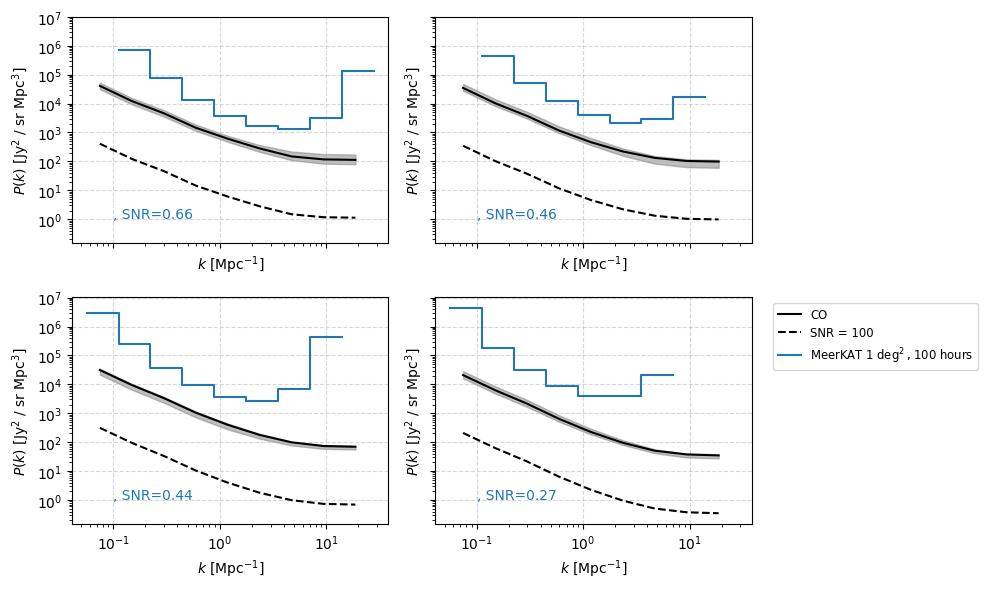

In [ ]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for j, exp in enumerate(HIexps.values()):
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCOsmedian[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label, color=f'C{j}')
        ax.text(.1, 1.1*(j+1)**4, f'SNR={np.nansum(SNR):.2f}', color=f'C{j}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [30]:
#save to csv
np.savetxt('./forjames.csv', np.array([KSs[0][1:-1], psCOsmedian[0], Pstd[0]]).T, delimiter=',', header='k, P(k), sigma_P(k)', comments='')

In [2]:
import pickle
with open('HIexps.pkl', 'wb') as f:
    pickle.dump(HIexps, f)

In [168]:
(((2 * cst.k_B * 1 * u.mK) ** 2 / (l.HI.l * (1+.4))**4) / u.Jy**2).decompose()

<Quantity 1020.55692752>

In [8]:
import pickle
with open('HIexps.pkl', 'rb') as f:
    HIexps = pickle.load(f)
print(HIexps.keys())

dict_keys(['MeerKAT_100_5000', 'MeerKAT_100_10000', 'MeerKAT_100_50000', 'MeerKAT_1_100', 'MeerKAT_1_5000', 'MeerKAT_1_2000', 'MeerKAT_1_500', 'MeerKAT_4_2000', 'MeerKAT_4_5000'])


In [345]:
import pickle
cross_exps = {}
with open('CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('HIexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['PTIM_1', 'PTIM_p2', 'TIM_NG', 'TIM_NG_9', 'SpTIM_4', 'SpTIM_9', 'SpTIM_100'])
dict_keys(['MeerKAT_100_5000', 'MeerKAT_100_10000', 'MeerKAT_100_50000', 'MeerKAT_1_100', 'MeerKAT_1_5000', 'MeerKAT_1_2000', 'MeerKAT_1_500', 'MeerKAT_4_2000', 'MeerKAT_4_5000'])


In [346]:
combos = [
    ('PTIM_1', 'MeerKAT_1_2000'),
    ('TIM_NG', 'MeerKAT_4_2000'),
    ('SpTIM_100', 'MeerKAT_100_5000')]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_hi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/3179927058.py:21: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


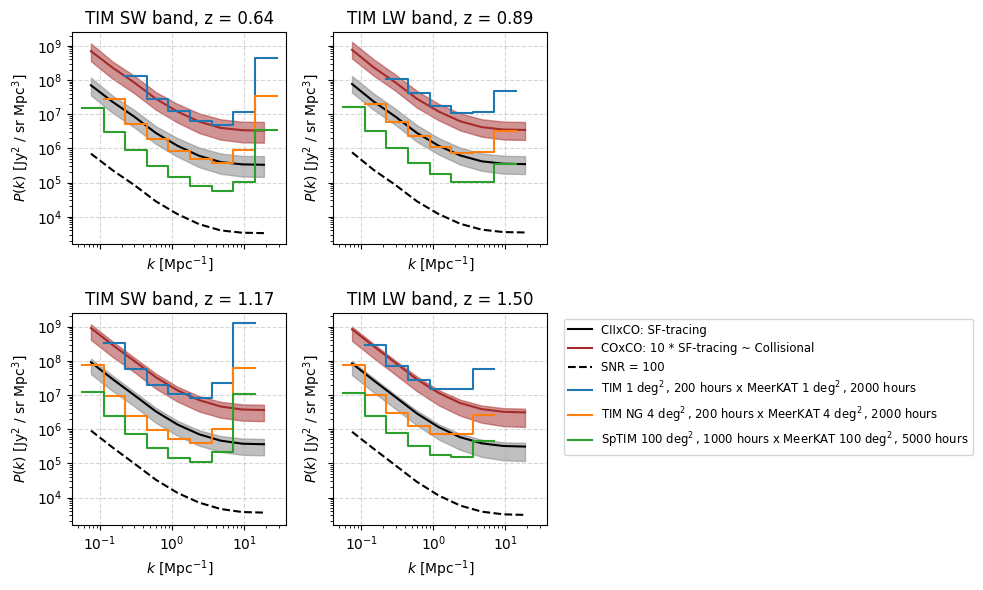

In [347]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in cross_exps.values():
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = (psCIIxCOmedian[i] / Pstd_exp[i])
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/2331807545.py:40: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


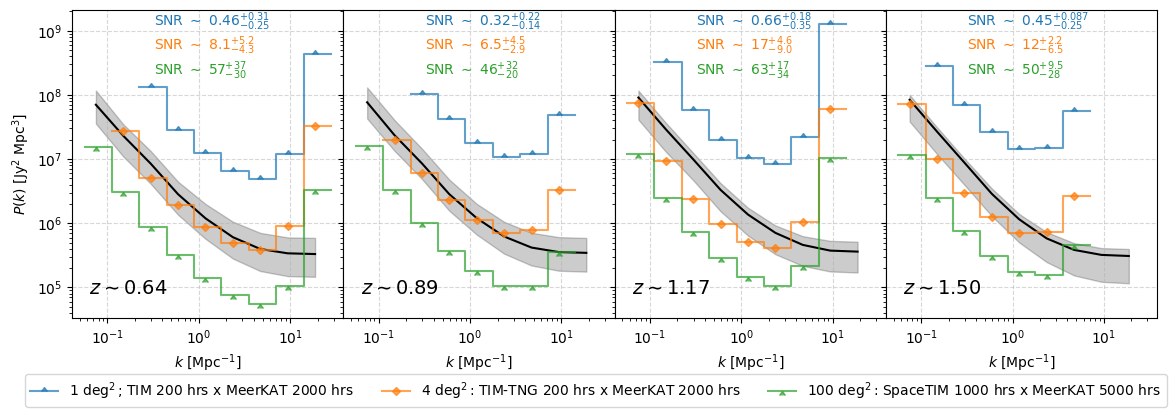

In [349]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'black'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; TIM 200 hrs x MeerKAT 2000 hrs",
    r"4 $\deg^2$: TIM-TNG 200 hrs x MeerKAT 2000 hrs",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x MeerKAT 5000 hrs"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
        
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s > 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        snrtext = r'SNR $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        ax.text(.3, .95-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    ax.text(.35, .08, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(-.2, -.16), loc='upper left', fontsize=10, ncol=3)

plt.savefig("../figs/preds/CIIxHI_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()

In [350]:
import pickle
cross_exps = {}
with open('HIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('COexps.pkl', 'rb') as f:
    COexps = pickle.load(f)

print(CIIexps.keys())
print(COexps.keys())

dict_keys(['MeerKAT_100_5000', 'MeerKAT_100_10000', 'MeerKAT_100_50000', 'MeerKAT_1_100', 'MeerKAT_1_5000', 'MeerKAT_1_2000', 'MeerKAT_1_500', 'MeerKAT_4_2000', 'MeerKAT_4_5000'])
dict_keys(['EoRSpec_DSS_TIM', 'EoRSpec_DSS', 'EoRSpec_wide'])


In [351]:
combos = [
    ('MeerKAT_1_2000', 'EoRSpec_DSS_TIM'),
    ('MeerKAT_4_2000', 'EoRSpec_DSS'),
    ('MeerKAT_100_5000', 'EoRSpec_wide')]

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = [np.load(FILENAME(Z)) for Z in Z_MODELING]

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_cohi'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = COexps[co_key]
    
    Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/481307873.py:21: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2 / w2)) / Nmode for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


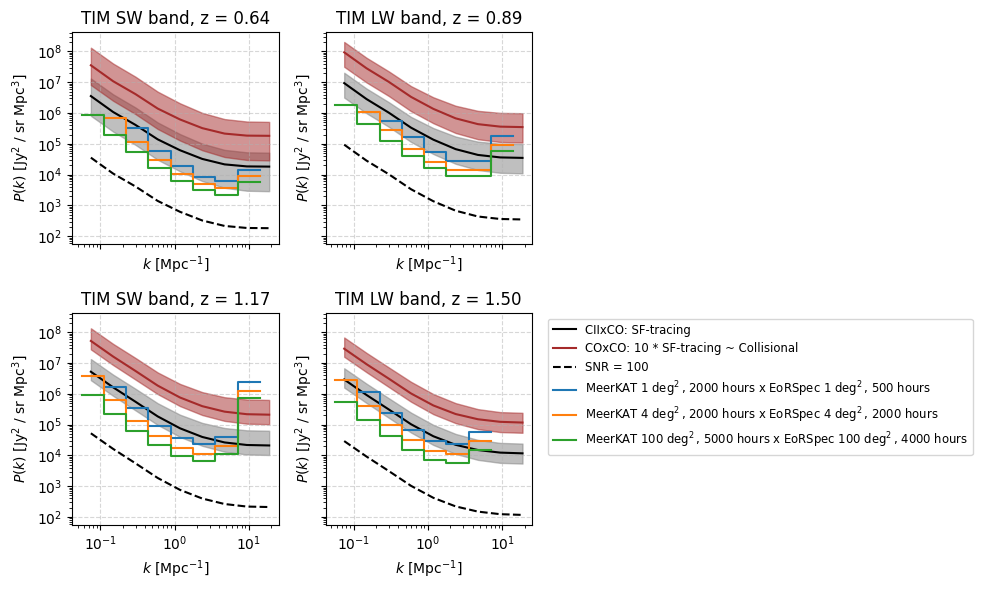

In [352]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color='black', label='CIIxCO: SF-tracing')
    
    ax.fill_between(KSs[i][1:-1], pslow[i] * 10, psup[i] * 10, color='brown', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] * 10, color='brown', label='COxCO: 10 * SF-tracing ~ Collisional')
    
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in cross_exps.values():
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        SNR = (psCIIxCOmedian[i] / Pstd_exp[i])
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {Z_MODELING[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_31173/4136622179.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


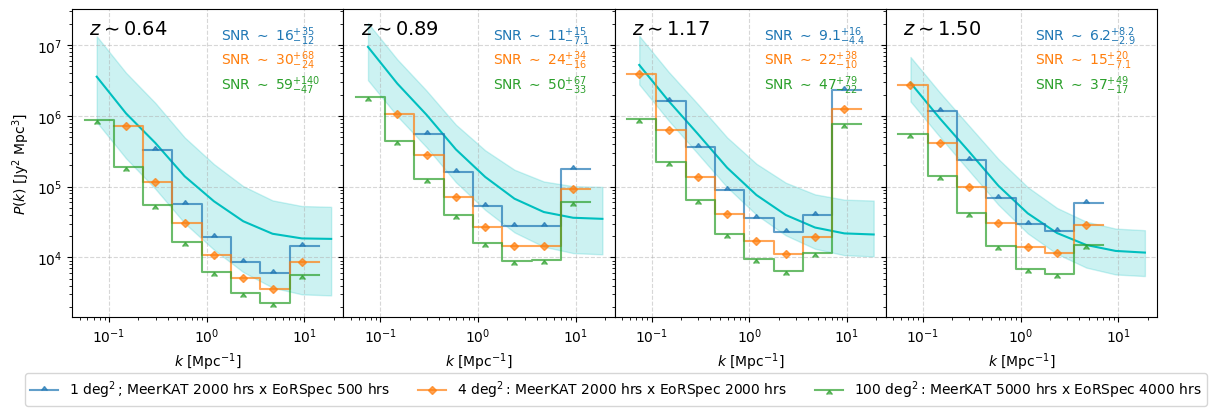

In [354]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'c'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; MeerKAT 2000 hrs x EoRSpec 500 hrs",
    r"4 $\deg^2$: MeerKAT 2000 hrs x EoRSpec 2000 hrs",
    r"100 $\deg^2$: MeerKAT 5000 hrs x EoRSpec 4000 hrs"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
        
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if s>1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
        
        snrtext = r'SNR $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        
        ax.text(.55, .9-.08*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    ax.text(.35, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)

axs[0].legend(bbox_to_anchor=(-.2, -.16), loc='upper left', fontsize=10, ncol=3)

plt.savefig("../figs/preds/COxHI_preds.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
plt.close()